In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV,cross_val_score
import random
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [2]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Data Preparation

In [3]:
train = pd.read_csv('../data/reduced_cleaned_files/train_reduced_cleaned_withNames.csv')
X_train = train.drop(['Activity'], axis=1)
y_train = train['Activity']
y_train = pd.DataFrame(y_train)

print('X_train and y_train : ({},{})'.format(X_train.shape, y_train.shape))

X_train and y_train : ((7261, 200),(7261, 1))


In [4]:
X_test = pd.read_csv('../data/reduced_files/X_test_reduced_UFS_withNames.csv')
y_test = pd.read_csv('../data/csv_files/y_test.csv')
#X_train = train.drop(['subject', 'Activity','ActivityName'], axis=1)

#y_train = train['Activity']
#y_train = pd.DataFrame(y_train)
print('X_test and y_test : ({},{})'.format(X_test.shape, y_test.shape))

X_test and y_test : ((2947, 200),(2947, 1))


# Analisi correlazione

In [404]:
def build_corr(X_tr):
    features = X_tr.columns 
    
    corr_list = list()
    for i, f1 in enumerate(features):
        for j, f2 in enumerate(features):
            corr_score = X_tr[[f1,f2]].corr()
            
            corr_list.append((f1, f2, corr_score))
    return corr_list

In [188]:
corr_list = build_corr(X_train)

In [191]:
#corr_list.sort(key = lambda x: x[2], reverse = True) 
corr_list

[('tBodyAccstdX',
  'tBodyAccstdX',
                tBodyAccstdX  tBodyAccstdX
  tBodyAccstdX           1.0           1.0
  tBodyAccstdX           1.0           1.0),
 ('tBodyAccstdX',
  'tBodyAccstdY',
                tBodyAccstdX  tBodyAccstdY
  tBodyAccstdX      1.000000      0.932928
  tBodyAccstdY      0.932928      1.000000),
 ('tBodyAccstdX',
  'tBodyAccstdZ',
                tBodyAccstdX  tBodyAccstdZ
  tBodyAccstdX      1.000000      0.857638
  tBodyAccstdZ      0.857638      1.000000),
 ('tBodyAccstdX',
  'tBodyAccmadX',
                tBodyAccstdX  tBodyAccmadX
  tBodyAccstdX      1.000000      0.998652
  tBodyAccmadX      0.998652      1.000000),
 ('tBodyAccstdX',
  'tBodyAccmadY',
                tBodyAccstdX  tBodyAccmadY
  tBodyAccstdX      1.000000      0.927777
  tBodyAccmadY      0.927777      1.000000),
 ('tBodyAccstdX',
  'tBodyAccmadZ',
                tBodyAccstdX  tBodyAccmadZ
  tBodyAccstdX      1.000000      0.854322
  tBodyAccmadZ      0.854322      1.000000)

# A. Linear Regression in 2 dimensions

- R2 is a measure of the goodness of fit of a mode
     - statistical measure of how well the regression predictions approximate the real data points. An R2 of 1 indicates that the regression predictions perfectly fit the data.
      - Di solito, più è grande il valore dell'R quadro, più il modello ha un alto potere predittivo. Più grande è il valore di R quadro, migliore è la capacità delle variabili esplicative di prevedere i valori della variabile dipendente.
- Values of R2 outside the range 0 to 1 occur when the model fits the data worse than the worst possible least-squares predictor (equivalent to a horizontal hyperplane at a height equal to the mean of the observed data).

### Come scegliere variabile indipendente e dipendente

Magnitude of an acceleration e Body Acceleration sembrano avere una distribuzione molto simile 

Ciò è ulteriormente provato dall'alta correlazione: 0.971935

In [228]:
X_train[['tBodyAccMagmean','tBodyAccstdY']].corr()

,tBodyAccMagmean,tBodyAccstdY
tBodyAccMagmean,1.000000,0.971935
tBodyAccstdY,0.971935,1.000000


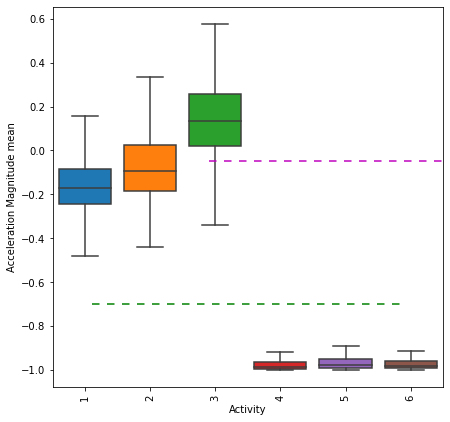

In [223]:
plt.figure(figsize=(7,7))
sns.boxplot(x='Activity', y='tBodyAccMagmean',data=train, showfliers=False, saturation=1)
plt.ylabel('Acceleration Magnitude mean')
plt.axhline(y=-0.7, xmin=0.1, xmax=0.9,dashes=(5,5), c='g')
plt.axhline(y=-0.05, xmin=0.4, dashes=(5,5), c='m')
plt.xticks(rotation=90)
plt.show()

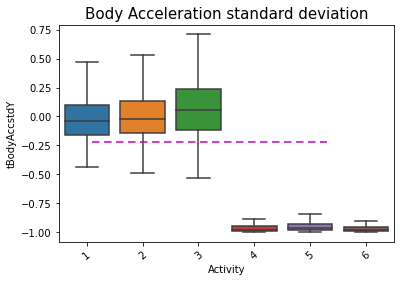

In [226]:
sns.boxplot(x='Activity', y='tBodyAccstdY', data = train, showfliers=False)
plt.title('Body Acceleration standard deviation', fontsize=15)
plt.xticks(rotation = 40)
plt.axhline(y=-0.22, xmin=0.1, xmax=0.8, dashes=(5,3), c='m')
plt.show()

### Variabili selezionate

In [5]:
# continuous dependent variable
DEP_VAR = 'tBodyAccMagmean'

# continuous independent variable
INDEP_VAR_1 = 'tBodyAccstdY'

In [6]:
X_train_linear = X_train[[INDEP_VAR_1, DEP_VAR]]

Text(0.5, 0, 'tBodyAccstdY')

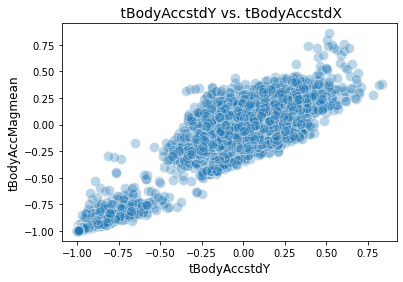

In [7]:
plt.scatter(y = DEP_VAR, x = INDEP_VAR_1, data = X_train_linear, s = 100, alpha = 0.3, edgecolor = 'white')
plt.title(' tBodyAccstdY vs. tBodyAccstdX', fontsize = 14)
plt.ylabel(DEP_VAR, fontsize = 12)
plt.xlabel(INDEP_VAR_1, fontsize = 12)

In [8]:
# independent variable
X_var = X_train_linear[[INDEP_VAR_1]]

#dependent variable
y_var = X_train_linear[[DEP_VAR]]

# independent variable
#X_ts = X_test[[INDEP_VAR_1]]

#dependent variable
#y_ts = X_test[[DEP_VAR]]

In [9]:
X, X_test, y, y_test = train_test_split(X_var, y_var, test_size=0.30 ,random_state=42) # NON si fa


In [10]:
#Function to get cross validation score R2
def get_cv_scores(model,X_train,y_train):
    scores = cross_val_score(model,
                             X_train,
                             y_train,
                             cv=3,
                             scoring='r2')
    
    print('CV Mean (R2): ', np.mean(scores))
    print('STD: ', np.std(scores))
    print('\n')

## A.1) Simple Linear Regression

In [11]:
# build the model
slr = LinearRegression()
slr.fit(X,y)
y_pred = slr.predict(X_test)

In [13]:
#Evaluations
print("***Cross Validation R2 score - Test Data***")
get_cv_scores(slr,X_test,y_test) #R2 cv on training data

print("***Scores (no cv) on Test Data***")
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

***Cross Validation R2 score - Test Data***
CV Mean (R2):  0.9436457105732586
STD:  0.0017404496888244782


***Scores (no cv) on Test Data***
R2: 0.944
MSE: 0.013
MAE: 0.067


In [14]:
# Compute hypotesis weight and bias

# Y = wX+B where X=valence and Y=danceability
slr_slope = slr.coef_ # weight: w
slr_intercept = slr.intercept_ # bias B
print('Coefficients: \n', slr_slope)
print('Intercept: \n', slr_intercept)

Coefficients: 
 [[0.92379948]]
Intercept: 
 [-0.07186748]


Text(0.5, 0, 'tBodyAccstdY')

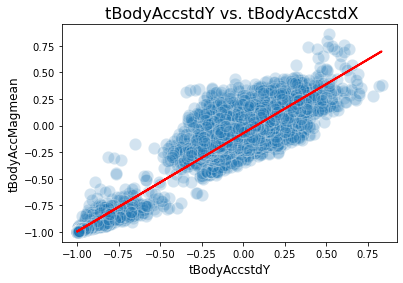

In [15]:
import seaborn as sns
# plot the regression function
sns.scatterplot(x = INDEP_VAR_1, y = DEP_VAR, data = X_train_linear , s = 150, alpha = 0.2, edgecolor = 'white')
#plt.plot(X_train_linear[INDEP_VAR_1], slr_slope*X_train_linear[[INDEP_VAR_1]] + slr_intercept, color = 'r', linewidth = 2)
plt.plot(X_test[INDEP_VAR_1].values, y_pred, color = 'r', linewidth = 2)


plt.title(' tBodyAccstdY vs. tBodyAccstdX', fontsize = 16)
plt.ylabel(DEP_VAR, fontsize = 12)
plt.xlabel(INDEP_VAR_1, fontsize = 12)

C:\Users\info\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\info\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


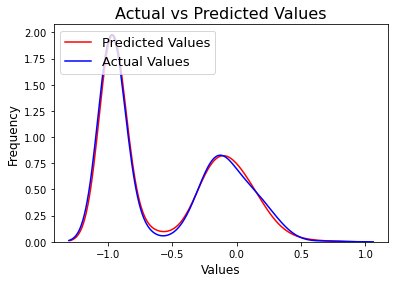

In [16]:
# I valori compresi tra 0.3 e 0.55 vengono predetti più volte di quanto realmente appaiono nella distribuzione.

# Plot frequency of predicted and actual values
sns.distplot(y_pred, hist = False, color = 'r', label = 'Predicted Values')
sns.distplot(y_test, hist = False, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)

## A.2)  Lasso Simple Linear Regression (L1 Regularization)

### A.2.1) Senza ottimizzazione aplha 

In [17]:
lasso_slr = Lasso(alpha=0.001)
lasso_slr.fit(X,y)
y_pred = lasso_slr.predict(X_test)

In [18]:
#Evaluations
print("***Cross Validation R2 score - Test Data***")
get_cv_scores(lasso_slr,X_test,y_test) #R2 cv on training data

print("***Scores (no cv) on Test Data***")
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

***Cross Validation R2 score - Test Data***
CV Mean (R2):  0.9436277255934667
STD:  0.0017515975381109964


***Scores (no cv) on Test Data***
R2: 0.944
MSE: 0.013
MAE: 0.068


In [19]:
lasso_slr_slope = lasso_slr.coef_ 
lasso_slr_intercept = lasso_slr.intercept_ 
print('Coefficients: \n', lasso_slr.coef_)
print('Intercept: \n', lasso_slr.intercept_)

Coefficients: 
 [0.9198355]
Intercept: 
 [-0.07390366]


Text(0.5, 0, 'tBodyAccstdY')

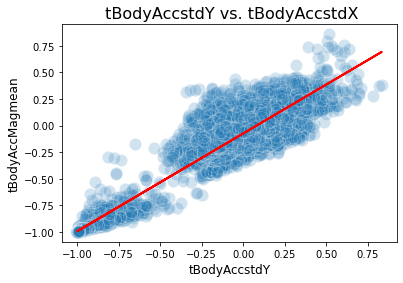

In [20]:

# plot the regression function
sns.scatterplot(x = INDEP_VAR_1, y = DEP_VAR, data = X_train_linear , s = 150, alpha = 0.2, edgecolor = 'white')
#plt.plot(X_train_linear[INDEP_VAR_1], slr_slope*X_train_linear[[INDEP_VAR_1]] + slr_intercept, color = 'r', linewidth = 2)
plt.plot(X_test[INDEP_VAR_1].values, y_pred, color = 'r', linewidth = 2)


plt.title(' tBodyAccstdY vs. tBodyAccstdX', fontsize = 16)
plt.ylabel(DEP_VAR, fontsize = 12)
plt.xlabel(INDEP_VAR_1, fontsize = 12)

C:\Users\info\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\info\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


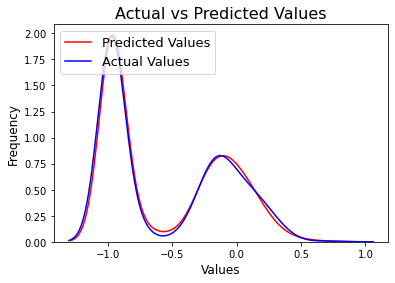

In [21]:

# Plot frequency of predicted and actual values
sns.distplot(y_pred, hist = False, color = 'r', label = 'Predicted Values')
sns.distplot(y_test, hist = False, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)

### A.2.1) Con ottimizzazione aplha 

In [22]:
alpha = [0.1, 0.01,0.001,0.0001,0.00001,0.000001,0.0000001]
param_grid = dict(alpha=alpha)

In [23]:
lasso_slr = Lasso()
grid = RandomizedSearchCV(estimator=lasso_slr, param_distributions=param_grid, n_iter=30, cv = 3, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X, y)

C:\Users\info\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 7 is smaller than n_iter=30. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 7 candidates, totalling 21 fits


In [24]:
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Best Score:  0.9449930906272765
Best Params:  {'alpha': 1e-05}


In [25]:
lasso_slr = Lasso(alpha=0.00001)
lasso_slr.fit(X,y)
y_pred = lasso_slr.predict(X_test)

In [26]:
#Evaluations
print("***Cross Validation R2 score - Test Data***")
get_cv_scores(lasso_slr,X_test,y_test) #R2 cv on training data

print("***Scores (no cv) on Test Data***")
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

***Cross Validation R2 score - Test Data***
CV Mean (R2):  0.9436457061775027
STD:  0.0017405653322733342


***Scores (no cv) on Test Data***
R2: 0.944
MSE: 0.013
MAE: 0.067


In [27]:
lasso_slr_slope = lasso_slr.coef_ 
lasso_slr_intercept = lasso_slr.intercept_ 
print('Coefficients: \n', lasso_slr.coef_)
print('Intercept: \n', lasso_slr.intercept_)

Coefficients: 
 [0.92375984]
Intercept: 
 [-0.07188784]


Text(0.5, 0, 'tBodyAccstdY')

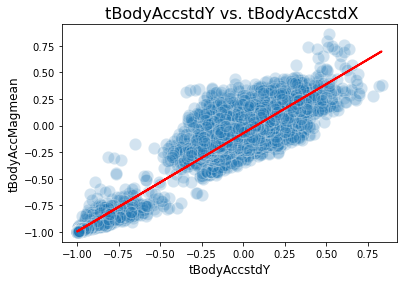

In [28]:
# plot the regression function
sns.scatterplot(x = INDEP_VAR_1, y = DEP_VAR, data = X_train_linear , s = 150, alpha = 0.2, edgecolor = 'white')
#plt.plot(X_train_linear[INDEP_VAR_1], slr_slope*X_train_linear[[INDEP_VAR_1]] + slr_intercept, color = 'r', linewidth = 2)
plt.plot(X_test[INDEP_VAR_1].values, y_pred, color = 'r', linewidth = 2)


plt.title(' tBodyAccstdY vs. tBodyAccstdX', fontsize = 16)
plt.ylabel(DEP_VAR, fontsize = 12)
plt.xlabel(INDEP_VAR_1, fontsize = 12)

C:\Users\info\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\info\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


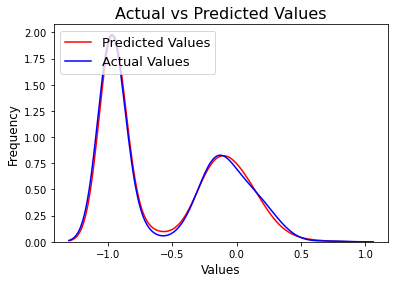

In [29]:
# Plot frequency of predicted and actual values
sns.distplot(y_pred, hist = False, color = 'r', label = 'Predicted Values')
sns.distplot(y_test, hist = False, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)

## A.3) Ridge Simple Linear Regression

### A.3.1) Senza ottimizzazione aplha 

In [30]:
ridge_slr = Ridge(alpha=0.0001)
ridge_slr.fit(X,y)
y_pred = ridge_slr.predict(X_test)

In [31]:
#Evaluations without grid search
print("***Cross Validation R2 score - Test Data***")
get_cv_scores(ridge_slr,X_test,y_test) #R2 cv on training data

print("***Scores (no cv) on Test Data***")
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

***Cross Validation R2 score - Test Data***
CV Mean (R2):  0.9436457105575098
STD:  0.0017404504177551982


***Scores (no cv) on Test Data***
R2: 0.944
MSE: 0.013
MAE: 0.067


In [32]:
ridge_slr_slope = ridge_slr.coef_ 
ridge_slr_intercept = ridge_slr.intercept_
print('Coefficients: \n', ridge_slr.coef_)
print('Intercept: \n', ridge_slr.intercept_)

Coefficients: 
 [[0.92379941]]
Intercept: 
 [-0.07186752]


Text(0.5, 0, 'tBodyAccstdY')

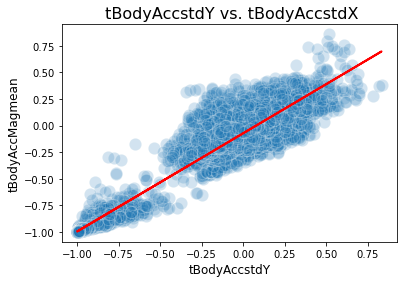

In [33]:
# plot the regression function
sns.scatterplot(x = INDEP_VAR_1, y = DEP_VAR, data = X_train_linear , s = 150, alpha = 0.2, edgecolor = 'white')
#plt.plot(X_train_linear[INDEP_VAR_1], slr_slope*X_train_linear[[INDEP_VAR_1]] + slr_intercept, color = 'r', linewidth = 2)
plt.plot(X_test[INDEP_VAR_1].values, y_pred, color = 'r', linewidth = 2)


plt.title(' tBodyAccstdY vs. tBodyAccstdX', fontsize = 16)
plt.ylabel(DEP_VAR, fontsize = 12)
plt.xlabel(INDEP_VAR_1, fontsize = 12)

C:\Users\info\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\info\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


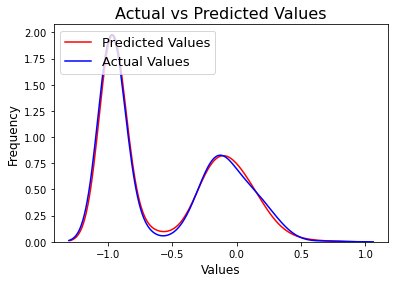

In [34]:

sns.distplot(y_pred, hist = False, color = 'r', label = 'Predicted Values')
sns.distplot(y_test, hist = False, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)

### A.3.2) Con ottimizzazione aplha 

In [35]:
# find optimal alpha with grid search
alpha = [random.uniform(1e-6,1e-1) for x in range(100000)]
param_grid = dict(alpha=alpha)

ridge_slr = Ridge()
grid = RandomizedSearchCV(estimator=ridge_slr, param_distributions=param_grid, n_iter=500, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X, y)

print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best Score:  0.9449147480170991
Best Params:  {'alpha': 0.09957265621769022}


In [36]:
ridge_slr = Ridge(alpha=0.09957265621769022)
ridge_slr.fit(X,y)
y_pred = ridge_slr.predict(X_test)

In [37]:
#Evaluations
print("***Cross Validation R2 score - Test Data***")
get_cv_scores(ridge_slr,X_test,y_test) #R2 cv on training data

print("***Scores (no cv) on Test Data***")
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

***Cross Validation R2 score - Test Data***
CV Mean (R2):  0.9436456251175249
STD:  0.0017411735698438261


***Scores (no cv) on Test Data***
R2: 0.944
MSE: 0.013
MAE: 0.067


In [38]:

ridge_slr_slope = ridge_slr.coef_ 
ridge_slr_intercept = ridge_slr.intercept_
print('Coefficients: \n', ridge_slr.coef_)
print('Intercept: \n', ridge_slr.intercept_)

Coefficients: 
 [[0.92372774]]
Intercept: 
 [-0.07190433]


Text(0.5, 0, 'tBodyAccstdY')

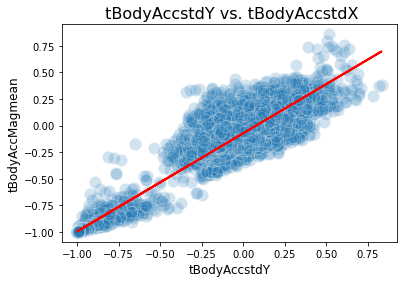

In [39]:
# plot the regression function
sns.scatterplot(x = INDEP_VAR_1, y = DEP_VAR, data = X_train_linear , s = 150, alpha = 0.2, edgecolor = 'white')
#plt.plot(X_train_linear[INDEP_VAR_1], slr_slope*X_train_linear[[INDEP_VAR_1]] + slr_intercept, color = 'r', linewidth = 2)
plt.plot(X_test[INDEP_VAR_1].values, y_pred, color = 'r', linewidth = 2)


plt.title(' tBodyAccstdY vs. tBodyAccstdX', fontsize = 16)
plt.ylabel(DEP_VAR, fontsize = 12)
plt.xlabel(INDEP_VAR_1, fontsize = 12)

C:\Users\info\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\info\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


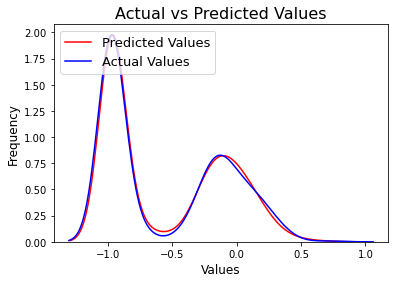

In [40]:
sns.distplot(y_pred, hist = False, color = 'r', label = 'Predicted Values')
sns.distplot(y_test, hist = False, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)

# B. Multivariate Linear Regression: MLR

### Come scegliere le altre variabili indipendenti

In [267]:
def search_corr(X_tr, DEP_VAR):
    features = X_tr.columns 
    
    corr_list = list()
    for VAR_IND in features:
        corr_score = X_tr[[DEP_VAR,VAR_IND]].corr().T.values[0][1]

        corr_list.append((DEP_VAR, VAR_IND, corr_score))
    return corr_list

In [268]:
corr_list = search_corr(X_train,'tBodyAccMagmean')

In [271]:
corr_list.sort(key = lambda x: x[2], reverse = True) 
corr_list

[('tBodyAccMagmean', 'tBodyAccMagmean', 1.0),
 ('tBodyAccMagmean', 'tBodyAccMagsma', 1.0),
 ('tBodyAccMagmean', 'tGravityAccMagmean', 1.0),
 ('tBodyAccMagmean', 'tGravityAccMagsma', 1.0),
 ('tBodyAccMagmean', 'tBodyAccsma', 0.9991832915250324),
 ('tBodyAccMagmean', 'fBodyAccsma', 0.9878263077722756),
 ('tBodyAccMagmean', 'tBodyAccstdX', 0.9833463889894503),
 ('tBodyAccMagmean', 'tBodyAccmadX', 0.9812417902037),
 ('tBodyAccMagmean', 'fBodyAccstdX', 0.9797580642144977),
 ('tBodyAccMagmean', 'fBodyAccmadX', 0.9795997297563602),
 ('tBodyAccMagmean', 'fBodyAccmeanX', 0.9780673754572762),
 ('tBodyAccMagmean', 'tBodyAccMagmad', 0.976259615944903),
 ('tBodyAccMagmean', 'tGravityAccMagmad', 0.976259615944903),
 ('tBodyAccMagmean', 'tBodyAccMagmax', 0.9747974930089307),
 ('tBodyAccMagmean', 'tGravityAccMagmax', 0.9747974930089307),
 ('tBodyAccMagmean', 'tBodyAccMagstd', 0.9743655989019138),
 ('tBodyAccMagmean', 'tGravityAccMagstd', 0.9743655989019138),
 ('tBodyAccMagmean', 'fBodyAccJerkentropyX'

PROVA 1 Scelto: 
- ('tBodyAccMagmean', 'tBodyAccsma', 0.9991832915250324), per correlazione positiva più alta possibile
- ('tBodyAccMagmean', 'tBodyAccminX', -0.9704988409604478), per correlazione negativa più alta possibile
- ('tBodyAccMagmean', 'tGravityAccmeanY', -0.5318958170319186), per correlazione negativa non molto alta
- ('tBodyAccMagmean', 'angleYgravityMean', 0.5104328582362133), per provare con una correlazione positiva non molto alta



In [41]:
# Si ha un R2 molto alto

INDEP_VAR_2 = 'tBodyAccsma'
INDEP_VAR_3 = 'tBodyAccminX'
INDEP_VAR_4 = 'tGravityAccmeanY'
INDEP_VAR_5 = 'angleYgravityMean'

PROVA 2 Scelto:
- ('tBodyAccMagmean', 'tGravityAccmaxX', 0.4149208188835662),
- ('tBodyAccMagmean', 'tGravityAccmeanX', 0.4028354446247097),
- ('tBodyAccMagmean', 'tGravityAccenergyX', 0.396633864506622),
- ('tBodyAccMagmean', 'tGravityAccminX', 0.3916240627855893),

In [42]:
# Variabili con corr basso

INDEP_VAR_2 = 'tGravityAccmaxX'
INDEP_VAR_3 = 'tGravityAccmeanX'
INDEP_VAR_4 = 'tGravityAccenergyX'
INDEP_VAR_5 = 'tGravityAccminX'

In [43]:
# independent variables
X_var = X_train[[INDEP_VAR_1,INDEP_VAR_2,INDEP_VAR_3,INDEP_VAR_4,INDEP_VAR_5]]

#dependent variable
y_var = X_train[[DEP_VAR]]

In [44]:
# split data in development and internal test
X, X_test, y, y_test = train_test_split(X_var, y_var, test_size=0.30 ,random_state=0)

## B.1) MLR simple model

In [45]:
# build the model (same as before)
mlr = LinearRegression()
mlr.fit(X,y)
y_pred = mlr.predict(X_test)

In [47]:
#Evaluations
print("***Cross Validation R2 score - Test Data***")
get_cv_scores(mlr,X_test,y_test) #R2 cv on training data

print("***Scores (no cv) on Test Data***")
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

***Cross Validation R2 score - Test Data***
CV Mean (R2):  0.9495760764266702
STD:  0.0035028458932075887


***Scores (no cv) on Test Data***
R2: 0.950
MSE: 0.011
MAE: 0.063


C:\Users\info\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\info\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


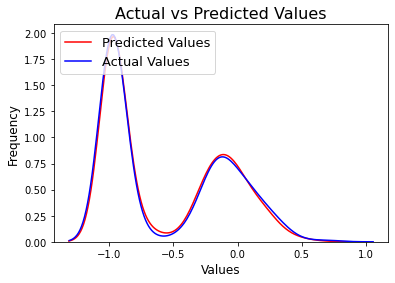

In [49]:
sns.distplot(y_pred, hist = False, color = 'r', label = 'Predicted Values')
sns.distplot(y_test, hist = False, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)

## B.2) MLR Lasso model (L1 Regularization)

In [50]:
# find optimal alpha with grid search
alpha = [random.uniform(1e-6,1) for x in range(100000)]
param_grid = dict(alpha=alpha)

In [51]:
lasso_mlr = Lasso()
grid = RandomizedSearchCV(estimator=lasso_mlr, param_distributions=param_grid, n_iter=500, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X, y)

print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best Score:  0.9433417353356809
Best Params:  {'alpha': 0.0002330269278750662}


In [52]:
lasso_mlr = Lasso(alpha=0.0002330269278750662)
lasso_mlr.fit(X,y)
y_pred = lasso_mlr.predict(X_test)

In [53]:
print("***Cross Validation R2 score - Test Data***")
get_cv_scores(lasso_mlr,X_test,y_test) #R2 cv on training data

print("***Scores (no cv) on Test Data***")
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

***Cross Validation R2 score - Test Data***
CV Mean (R2):  0.9485294554972606
STD:  0.004457650093651841


***Scores (no cv) on Test Data***
R2: 0.949
MSE: 0.012
MAE: 0.064


C:\Users\info\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\info\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


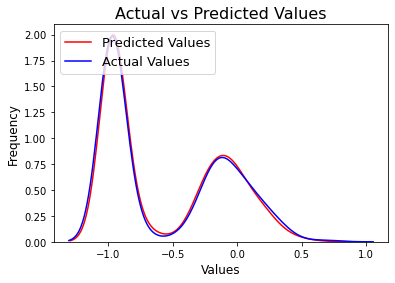

In [55]:
# Plot frequency of predicted and actual values
sns.distplot(y_pred, hist = False, color = 'r', label = 'Predicted Values')
sns.distplot(y_test, hist = False, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)

## B.3) MLR Ridge model (L2 Regularization)

In [56]:
# find optimal alpha with grid search
alpha = [random.uniform(1e-6,1) for x in range(100000)]
param_grid = dict(alpha=alpha)

ridge_mlr = Ridge()
grid = RandomizedSearchCV(estimator=ridge_mlr, param_distributions=param_grid, n_iter=500, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X, y)

print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best Score:  0.9440408147370782
Best Params:  {'alpha': 0.042606611052524265}


In [57]:
ridge_mlr = Ridge(alpha=0.042606611052524265)
ridge_mlr.fit(X,y)
y_pred = ridge_mlr.predict(X_test)

In [58]:
#Evaluations
print("***Cross Validation R2 score - Test Data***")
get_cv_scores(ridge_mlr,X_test,y_test) #R2 cv on training data

print("***Scores (no cv) on Test Data***")
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

***Cross Validation R2 score - Test Data***
CV Mean (R2):  0.9496324528222425
STD:  0.0038728703222120583


***Scores (no cv) on Test Data***
R2: 0.950
MSE: 0.011
MAE: 0.063


C:\Users\info\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\info\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


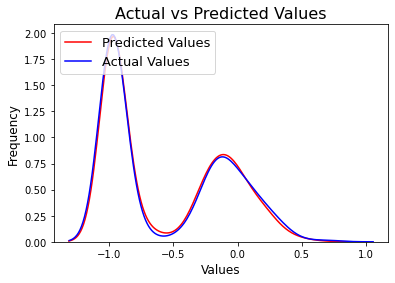

In [59]:
# Plot frequency of predicted and actual values
sns.distplot(y_pred, hist = False, color = 'r', label = 'Predicted Values')
sns.distplot(y_test, hist = False, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)

# C) Gradient Boost Regressor

In [60]:
from sklearn.ensemble import GradientBoostingRegressor

gradientBoost = GradientBoostingRegressor(random_state=42)
gradientBoost.fit(X.values,y.values.ravel())
y_pred = gradientBoost.predict(X_test.values)



In [64]:
#Evaluations
print("***Cross Validation R2 score - Test Data***")
get_cv_scores(gradientBoost,X_test.values,y_test.values.ravel()) #R2 cv on training data

print("***Scores (no cv) on Test Data***")
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

***Cross Validation R2 score - Test Data***
CV Mean (R2):  0.9615462207571204
STD:  0.0026241443249163045


***Scores (no cv) on Test Data***
R2: 0.964
MSE: 0.008
MAE: 0.053


# ALTRE RICERCHE (NON IMPORTANTI O SBAGLIATE)

### Ricerca di altre variabili 

In [245]:
def build_LinearRegression(X_tr):
    features = X_tr.columns 
    
    R2 = list()
    for i, f1 in enumerate(features):
        for j, f2 in enumerate(features):
            # continuous dependent variable
            DEP_VAR = f1

            # continuous independent variable
            INDEP_VAR_1 = f2
            X_TRAIN_LIN = X_tr[[INDEP_VAR_1, DEP_VAR]]
            
            # independent variable
            X_var = X_TRAIN_LIN[[INDEP_VAR_1]]
            #dependent variable
            y_var = X_TRAIN_LIN[[DEP_VAR]]
            X, X_test, y, y_test = train_test_split(X_var, y_var, test_size=0.30 ,random_state=42)

            
            slr = LinearRegression()
            slr.fit(X,y)
            y_pred = slr.predict(X_test)
            
            score_r2 = r2_score(y_test, y_pred)
            #if score_r2 ! 1:
            R2.append((DEP_VAR, INDEP_VAR_1, score_r2))
    return R2

In [246]:
R2 = build_LinearRegression(X_train)

In [247]:
R2.sort(key = lambda x: x[2], reverse = True) 
R2

[('tBodyAccstdX', 'tBodyAccstdX', 1.0),
 ('tBodyAccstdY', 'tBodyAccstdY', 1.0),
 ('tBodyAccstdZ', 'tBodyAccstdZ', 1.0),
 ('tBodyAccmadX', 'tBodyAccmadX', 1.0),
 ('tBodyAccmadY', 'tBodyAccmadY', 1.0),
 ('tBodyAccmadZ', 'tBodyAccmadZ', 1.0),
 ('tBodyAccmaxX', 'tBodyAccmaxX', 1.0),
 ('tBodyAccmaxY', 'tBodyAccmaxY', 1.0),
 ('tBodyAccmaxZ', 'tBodyAccmaxZ', 1.0),
 ('tBodyAccminX', 'tBodyAccminX', 1.0),
 ('tBodyAccminY', 'tBodyAccminY', 1.0),
 ('tBodyAccminZ', 'tBodyAccminZ', 1.0),
 ('tBodyAccsma', 'tBodyAccsma', 1.0),
 ('tBodyAccenergyX', 'tBodyAccenergyX', 1.0),
 ('tBodyAcciqrX', 'tBodyAcciqrX', 1.0),
 ('tBodyAcciqrY', 'tBodyAcciqrY', 1.0),
 ('tBodyAcciqrZ', 'tBodyAcciqrZ', 1.0),
 ('tBodyAccentropyX', 'tBodyAccentropyX', 1.0),
 ('tBodyAccentropyY', 'tBodyAccentropyY', 1.0),
 ('tGravityAccmeanX', 'tGravityAccmeanX', 1.0),
 ('tGravityAccmeanY', 'tGravityAccmeanY', 1.0),
 ('tGravityAccmaxX', 'tGravityAccmaxX', 1.0),
 ('tGravityAccmaxY', 'tGravityAccmaxY', 1.0),
 ('tGravityAccminX', 'tGravityAc

In [173]:
def build_LinearRegression(X_tr, X_ts, y_ts):
    features = X_tr.columns 
    
    R2 = list()
    for i, f1 in enumerate(features):
        for j, f2 in enumerate(features):
            dip = f1
            ind = f2
            reg = LinearRegression()
            
            scaler = StandardScaler()
            scaler.fit(X_tr)
            X_tr = scaler.transform(X_tr)
            X_ts = scaler.transform(X_ts)
            reg.fit(X_tr[:, i].reshape(-1, 1), X_tr[:, j].reshape(-1, 1))
            y_pred = reg.predict(X_ts[:, i].reshape(-1, 1)).reshape(1,-1)[0]
            
            score_r2 = r2_score(y_ts, y_pred)
            #if score_r2 ! 1:
            R2.append((dip, ind, score_r2))
    return R2

In [174]:
R2 = build_LinearRegression(X_train, X_test, y_test)

In [175]:
R2.sort(key = lambda x: x[2], reverse = True) 
R2

[('tBodyAccmadZ', 'tBodyAccminZ', -3.5587881627817337),
 ('tBodyAcciqrZ', 'tBodyAccminZ', -3.5628673804137643),
 ('fBodyAccstdZ', 'tBodyAccminZ', -3.5667464791285672),
 ('tBodyAccstdZ', 'tBodyAccminZ', -3.5676005020242227),
 ('tBodyAcciqrZ', 'tBodyGyrominZ', -3.5741568190496293),
 ('tBodyAcciqrZ', 'tBodyAccminX', -3.579410957572505),
 ('tBodyAcciqrZ', 'tBodyAccminY', -3.584866880929634),
 ('tBodyAccmadZ', 'tBodyGyrominZ', -3.5855555540469535),
 ('tBodyAccmadZ', 'tBodyAccJerkminZ', -3.5877124800568643),
 ('tBodyAcciqrZ', 'tBodyAccJerkminX', -3.5886968779221275),
 ('tBodyAcciqrZ', 'tBodyAccJerkminZ', -3.5910967615602276),
 ('tBodyAccmadZ', 'tBodyAccminX', -3.591521575547496),
 ('tBodyAccmadZ', 'tBodyAccminY', -3.59529470786169),
 ('tBodyAccstdZ', 'tBodyAccJerkminZ', -3.5959926002886275),
 ('fBodyAccstdZ', 'tBodyGyrominZ', -3.5979286541724864),
 ('tBodyAccmadZ', 'tBodyAccJerkminX', -3.5986068406729794),
 ('tBodyGyroJerkiqrX', 'tBodyGyroJerkminX', -3.5993205681466405),
 ('tBodyAccstdZ', 't

In [ ]:
tBodyAccstdX  

In [193]:
reg = LinearRegression()
#reg.fit(X_train.T[0].values.reshape(-1, 1), X_train.T[1].values.reshape(-1, 1))
reg.fit(X_train['tBodyAccstdY'].values.reshape(-1, 1), X_train['tBodyAccstdX'].values.reshape(-1, 1))

y_pred = reg.predict(X_test['tBodyAccstdX'].values.reshape(-1, 1)).reshape(1,-1)[0]
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: -6.346
MSE: 22.241
MAE: 4.266


In [180]:
reg = LinearRegression()
#reg.fit(X_train.T[0].values.reshape(-1, 1), X_train.T[1].values.reshape(-1, 1))
reg.fit(X_train['tBodyAccmadZ'].values.reshape(-1, 1), X_train['tBodyAccminZ'].values.reshape(-1, 1))

y_pred = reg.predict(X_test['tBodyAccmadZ'].values.reshape(-1, 1)).reshape(1,-1)[0]
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: -2.703
MSE: 11.211
MAE: 2.965


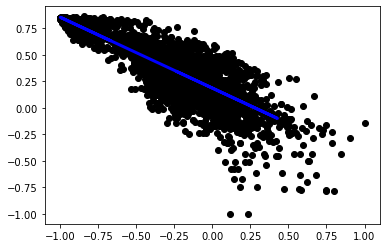

In [181]:
plt.scatter(X_train['tBodyAccmadZ'].values, X_train['tBodyAccminZ'].values,  color='black')
plt.plot(X_test['tBodyAccmadZ'].values, y_pred, color='blue', linewidth=3, label='test')
plt.show()

In [141]:
reg = LinearRegression()
#reg.fit(X_train.T[0].values.reshape(-1, 1), X_train.T[1].values.reshape(-1, 1))
reg.fit(X_train['tBodyGyroJerkmadX'].values.reshape(-1, 1), X_train['tBodyGyroJerkminX'].values.reshape(-1, 1))

y_pred = reg.predict(X_test['tBodyGyroJerkmadX'].values.reshape(-1, 1)).reshape(1,-1)[0]
print(X_train['tBodyGyroJerkmadX'].values.reshape(-1, 1).shape)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

(7261, 1)
R2: -2.406
MSE: 10.312
MAE: 2.811


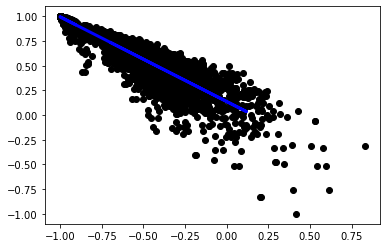

In [124]:
plt.scatter(X_train['tBodyGyroJerkmadX'].values, X_train['tBodyGyroJerkminX'].values,  color='black')
plt.plot(X_test['tBodyGyroJerkmadX'].values, y_pred, color='blue', linewidth=3, label='test')
plt.show()

In [87]:
reg = LinearRegression()
#reg.fit(X_train.T[0].values.reshape(-1, 1), X_train.T[1].values.reshape(-1, 1))
reg.fit(X_train['tBodyAccstdY'].values.reshape(-1, 1), X_train['tBodyAccMagmean'].values.reshape(-1, 1))

y_pred = reg.predict(X_test['tBodyAccstdY'].values.reshape(-1, 1)).reshape(1,-1)[0]

print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: -6.102
MSE: 21.502
MAE: 4.120


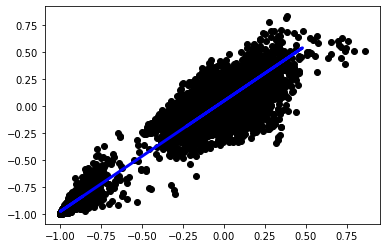

In [86]:
plt.scatter(X_train['tBodyAccMagmean'].values, X_train['tBodyAccstdY'].values,  color='black')
plt.plot(X_test['tBodyAccMagmean'].values, y_pred, color='blue', linewidth=3, label='test')
plt.show()